# Test with simple beam and spin dynamics

In [13]:
# leading zeros
number = 9
print("{:01d}".format(number))
print("{:02d}".format(number))
print("{:03d}".format(number))

9
09
009


In [1]:
import sys, os, shutil
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt


sys.path.insert(1,'../02_positron_sampling')
from PositronDecay import GenerateMichelKinematics, GeneratePositron_MRF, Calculate_Phase, GeneratePositron_LAB
from Constants import EMMU, EMASS, pi, twopi, fine_structure_const

Welcome to JupyROOT 6.24/00


In [2]:
# to be merged with constants.py after cosistency check
# CONSTANTS from gm2ringsim
# https://cdcvs.fnal.gov/redmine/projects/gm2geom/repository/revisions/master/entry/common/Gm2Constants_service.cc

# fundamental constants
mMuon = 105.6583715 # Source is 2012 PDG
aMuon = 11659208.9e-10 # Source is 2012 PDG (avg of mu+ and mu-)
eMuon = 0.0 # EDM
BMagic = 1.45126 # Magnitude of E821 field
c_light = 299792458
R_magic=7112

# kinematic constants derived from aMuon
pMagic= mMuon/np.sqrt(aMuon)
gammaMagic=np.sqrt(1.+1./aMuon)
betaMagic=np.sqrt( 1.-1./(gammaMagic*gammaMagic))
EMagic= gammaMagic*mMuon
KEMagic= EMagic - mMuon

# precession frequencies from aMuon and kinematics constants
omegaAMagic=aMuon*gammaMagic*betaMagic*c_light/R_magic # kHz
omegaCMagic=betaMagic*c_light/R_magic # kHz
omegaSMagic=omegaCMagic + omegaAMagic # kHz

# precession angles
get_theta_c = lambda t:omegaCMagic/1000*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:omegaSMagic/1000*t # spin precession, phase set to 0

# for checking
print("p = ",pMagic)
print("\n fa = {} MHz".format(omegaAMagic/(2*np.pi)/1000)," omegaA = {}".format(omegaAMagic/1000))
print("\n fc = {} MHz".format(omegaCMagic/(2*np.pi)/1000)," omegaC = {}".format(omegaCMagic/1000))
print("\n fs = {} MHz".format(omegaSMagic/(2*np.pi)/1000)," omegaC = {}".format(omegaSMagic/1000))

p =  3094.349543318504

 fa = 0.2290781295850034 MHz  omegaA = 1.4393403380046748

 fc = 6.704957935377404 MHz  omegaC = 42.12849318482048

 fs = 6.934036064962407 MHz  omegaC = 43.567833522825154


# generate E,PXYZ,xyzt
## continuous time (from uniform random numbers)
## Y is 0 or uniform random numbers

In [3]:
N_per_fill = 10000

def GenerateFill(j):
    """
    returns:
    0-PosiInitE
    1-PosiInitPX
    2-PosiInitPY
    3-PosiInitPZ
    4-muDecayPX
    5-muDecayPY
    6-muDecayPZ
    7-muDecayPolX
    8-muDecayPolY
    9-muDecayPolZ
    10-g2phase
    11-cos(g2phase)
    12-posiInitPosX
    13-posiInitPosY
    14-posiInitPosZ
    15-posiInitTime
    """
    # with time randomization
    print ("Fill: ",j) # to use a function for multiprocessing.pool, function has to take 1 argument
    
    four_momenta_LAB = np.zeros(shape=(N_per_fill,16))
    
    # initialize time and angles
    t_pts = 700*np.random.random(size=N_per_fill) # continuous time in 700 us
    cyclotron_angles = get_theta_c(t_pts)
    spin_precession_angles = get_theta_s(t_pts)
    
    # save posiInitTime and position in LAB frame [mm]  
    four_momenta_LAB[:,12] = 7112*np.cos(theta_c) # posiInitPosX
    four_momenta_LAB[:,13] = 0 # np.random.uniform(-45,45) # posiInitPosY 
    four_momenta_LAB[:,14] = 7112*np.sin(theta_c) # posiInitPosZ
    four_momenta_LAB[:,15] = t_pts  # posiInitTime

    for i in range(N_per_fill):
        # positrons in MRF
        theta_s = spin_precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[i,7] = muDecayPolX
        four_momenta_LAB[i,8] = muDecayPolY
        four_momenta_LAB[i,9] = muDecayPolZ

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                                four_momenta_LAB[i,7], four_momenta_LAB[i,9])
        four_momenta_LAB[i,10] = phase # g2phase
        four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

# 2.0 Parallel run

In [4]:
from multiprocessing import Pool,cpu_count

N_cpu_avail = cpu_count()

if (N_cpu_avail>16):
    N_cpu_selected = int(N_cpu_avail/4) # conservative ratio

else:
    if (N_cpu_avail>8):
        N_cpu_selected = 4
    else:
        N_cpu_selected = 1
        
print ("available cpu :",N_cpu_avail,"\n cpu selected: ",N_cpu_selected)

available cpu : 72 
 cpu selected:  18


In [5]:
N_per_fill = 1000000
N_cpu_selected = 10 # overide auto choosing
N_fills = 10 # number of fills that you want to produce

# parallelization
pool = Pool(processes=N_cpu_selected)
fills = pool.map(GenerateFill, range(N_fills))
pool.close()
pool.join()

# collect all fills
four_momenta_LAB = np.vstack(fills)

Fill: Fill: Fill:  Fill: Fill: Fill: Fill: Fill: Fill:  Fill: 0       1
 237469
58









In [7]:
# import os
# nick_name = "test" # nick name to be given to the dataset
# data_path = './data_{}'.format(nick_name)
# fname = os.path.join(data_path,'03_four_momenta_LAB.npy')

np.save('./data/test.npy',four_momenta_LAB)

In [2]:
four_momenta_LAB = np.load('data_run/run_1_1.npy') # to compare discrete time,use : "xdata_discreteTime/10Mxzt_y0_dt0.001.npy"  np.load('./data/1Mxzt_y0_dt0.01.npy')

# 1.0 Test with simple beam and spin dynamics (1.4 is the OK)

# 1.1 without time randomization

In [3]:
# for more complete bd, pls go to
# https://cdcvs.fnal.gov/redmine/projects/gm2ringsim/repository/revisions/develop/entry/actions/PGA/GasGunBdyn/GasGunBdyn_service.cc

# for crude test, use this
# data from E989 Note 205: The Beam Dynamics Model (Sweigart)
# note: this setting yields w_a = 1.430 (slightly different from gm2ringsim, 1.439)
# if you fix wa in toyMC and gm2ringsim fitting, be careful!
w_s = twopi/0.1443 # spin precession frequency = 6.9315 MHz (0.1443 us)
w_c = twopi/0.1492 # cyclotron period 0.2291 MHz (149.2 ns ~ 0.1 us)
w_a = w_s - w_c # 1.4300156624278344

get_theta_c = lambda t:w_c*t # cyclotron motion, phase set to 0; t in us, w in MHz
get_theta_s = lambda t:w_s*t # spin precession, phase set to 0; t in us, w in MHz

dt = 0.1 # steps in us
N_pts = int(700/dt) # discretize 700 us in steps of dt

cyclotron_angles = get_theta_c(np.arange(N_pts)*dt)
precession_angles = get_theta_s(np.arange(N_pts)*dt)

In [3]:
def GenerateFill(j):
    print ("Fill: ",j) # to use a function for multiprocessing.pool, function has to take 1 argument
    
    four_momenta_LAB = np.zeros(shape=(N_pts,12))

    for i in range(N_pts):
        # positrons in MRF
        theta_s = precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[:,7] = muDecayPolX
        four_momenta_LAB[:,8] = muDecayPolY
        four_momenta_LAB[:,9] = muDecayPolZ  

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                                four_momenta_LAB[i,7], four_momenta_LAB[i,9])
        four_momenta_LAB[i,10] = phase # g2phase
        four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

# 1.2 with time randomization

In [12]:
dt = 0.1 # steps in us
N_pts = int(700/dt) # discretize 700 us in steps of dtdt = 0.1
t_pts_base = np.arange(N_pts)*dt

get_theta_c = lambda t:2*np.pi/0.1492*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:2*np.pi/0.1443*t # spin precession, phase set to 0

# do time randomization, to sample more points in between
# t_pts = t_pts_base + np.random.uniform(low=-0.5*dt,high=.5*dt,size=N_pts)

# cyclotron_angles = get_theta_c(np.arange(t_pts))
# spin_precession_angles = get_theta_s(np.arange(t_pts))

In [13]:
def GenerateFill(j):
    # with time randomization
    print ("Fill: ",j) # to use a function for multiprocessing.pool, function has to take 1 argument
    
    four_momenta_LAB = np.zeros(shape=(N_pts,12))
    
    t_pts = t_pts_base + np.random.uniform(low=-0.5*dt,high=0.5*dt,size=N_pts)
    cyclotron_angles = get_theta_c(t_pts)
    spin_precession_angles = get_theta_s(t_pts)

    for i in range(N_pts):
        # positrons in MRF
        theta_s = spin_precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[i,7] = muDecayPolX
        four_momenta_LAB[i,8] = muDecayPolY
        four_momenta_LAB[i,9] = muDecayPolZ  

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                                four_momenta_LAB[i,7], four_momenta_LAB[i,9])
        four_momenta_LAB[i,10] = phase # g2phase
        four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

# 1.3 produce xyzt, with time randomization

In [5]:
dt = 0.1 # steps in us
N_pts = int(700/dt) # discretize 700 us in steps of dtdt = 0.1
t_pts_base = np.arange(N_pts)*dt

get_theta_c = lambda t:2*np.pi/0.1492*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:2*np.pi/0.1443*t # spin precession, phase set to 0

In [3]:
def GenerateFill(j):
    # with time randomization
    print ("Fill: ",j) # to use a function for multiprocessing.pool, function has to take 1 argument
    
    four_momenta_LAB = np.zeros(shape=(N_pts,16))
    
    t_pts = t_pts_base + np.random.uniform(low=-0.5*dt,high=0.5*dt,size=N_pts)
    cyclotron_angles = get_theta_c(t_pts)
    spin_precession_angles = get_theta_s(t_pts)

    four_momenta_LAB[:,15] = t_pts # posiInitTime

    for i in range(N_pts):
        # positrons in MRF
        theta_s = spin_precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[i,7] = muDecayPolX
        four_momenta_LAB[i,8] = muDecayPolY
        four_momenta_LAB[i,9] = muDecayPolZ
        
        # position in LAB frame [mm]      
        four_momenta_LAB[i,12] = 7112*np.cos(theta_c) # posiInitPosX
        four_momenta_LAB[i,13] = 0 # posiInitPosY # np.random.uniform(-45,45)
        four_momenta_LAB[i,14] = 7112*np.sin(theta_c) # posiInitPosZ

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                                four_momenta_LAB[i,7], four_momenta_LAB[i,9])
        four_momenta_LAB[i,10] = phase # g2phase
        four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

# 1.4*** produce xyzt, with continuous time (from uniform random numbers)

In [7]:
N_per_fill = 10000
get_theta_c = lambda t:2*np.pi/0.1492*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:2*np.pi/0.1443*t # spin precession, phase set to 0

def GenerateFill(j):
    # with time randomization
    print ("Fill: ",j) # to use a function for multiprocessing.pool, function has to take 1 argument
    
    four_momenta_LAB = np.zeros(shape=(N_per_fill,16))
    
    t_pts = 700*np.random.random(size=N_per_fill) # continuous time in 700 us
    cyclotron_angles = get_theta_c(t_pts)
    spin_precession_angles = get_theta_s(t_pts)

    four_momenta_LAB[:,15] = t_pts # posiInitTime

    for i in range(N_per_fill):
        # positrons in MRF
        theta_s = spin_precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[i,7] = muDecayPolX
        four_momenta_LAB[i,8] = muDecayPolY
        four_momenta_LAB[i,9] = muDecayPolZ
        
        # position in LAB frame [mm]      
        four_momenta_LAB[i,12] = 7112*np.cos(theta_c) # posiInitPosX
        four_momenta_LAB[i,13] = 0 # posiInitPosY # np.random.uniform(-45,45)
        four_momenta_LAB[i,14] = 7112*np.sin(theta_c) # posiInitPosZ

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                                four_momenta_LAB[i,7], four_momenta_LAB[i,9])
        four_momenta_LAB[i,10] = phase # g2phase
        four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

In [13]:
import time, datetime

N_per_fill = 1000000
start_time = time.time()
z=GenerateFill(1)
print("--- time taken for michel: %s ---" % (str(datetime.timedelta(seconds=time.time() - start_time))))

Fill:  1
--- time taken for michel: 0:03:47.024602 ---


In [12]:
z[:,15]

array([189.17868178, 391.80510754, 668.3237277 , ..., 523.95443804,
       646.17255433, 280.71728979])

# 2.0 Parallel run

In [4]:
from multiprocessing import Pool,cpu_count

N_cpu_avail = cpu_count()

if (N_cpu_avail>16):
    N_cpu_selected = int(N_cpu_avail/4) # conservative ratio

else:
    if (N_cpu_avail>8):
        N_cpu_selected = 4
    else:
        N_cpu_selected = 1
        
print ("available cpu :",N_cpu_avail,"\n cpu selected: ",N_cpu_selected)

available cpu : 72 
 cpu selected:  18


In [6]:
N_cpu_selected = 16 # overide auto choosing
N_fills = 16 # number of fills that you want to produce

# parallelization
pool = Pool(processes=N_cpu_selected)
fills = pool.map(GenerateFill, range(N_fills))
pool.close()
pool.join()

# collect all fills
four_momenta_LAB = np.vstack(fills)

Fill: Fill: Fill: Fill: Fill: Fill: Fill: Fill: Fill: Fill: Fill: Fill:  Fill:  Fill: Fill: Fill:          1 0  3  241456789
10
1112
1513














In [7]:
# import os
# nick_name = "test" # nick name to be given to the dataset
# data_path = './data_{}'.format(nick_name)
# fname = os.path.join(data_path,'03_four_momenta_LAB.npy')

np.save('./data/test.npy',four_momenta_LAB)

In [2]:
four_momenta_LAB = np.load('data_run/run_1_1.npy') # to compare discrete time,use : "xdata_discreteTime/10Mxzt_y0_dt0.001.npy"  np.load('./data/1Mxzt_y0_dt0.01.npy')

# visualize and compare result with simulation using random angles $\theta_c$, $\theta_s$ 

In [3]:
r.gInterpreter.Declare("""
//#include <math.h>

double Phase(double y1, double x1, double y2, double x2) {
   /* compute the angle difference between vector1 and vector2 given their x,y components. */
   
   double ans1 = atan2(y1,x1);  //angle of vector 1, muDecayP
   double ans2 = atan2(y2,x2);  //angle of vector 2, muDecayPol
   double ans = ans1 - ans2;
   
   if(ans<0){
       ans = ans+2*M_PI;
    }
       
   return ans;
}
""")

# load gm2ringsim data
fname = "/home/junkai.ng/junkai.ng/CaloMC/gm2ringsim_muon_gasgun_ana_21378178_1.root"
df = r.RDataFrame("G2PhaseAnalyzer/g2phase",fname)
df = df.Define("g2phase", "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)") 
df = df.Define("cosg2phase", "cos(g2phase)") 
varList = ["posiInitE","posiInitPX","posiInitPY","posiInitPZ","g2phase","cosg2phase"]
data_gm2ringsim = df.AsNumpy(columns=varList)

ReadStreamerInfo, class:string, illegal uid=-2


Warning in <TClass::Init>: no dictionary for class __basic_string_common<true> is available


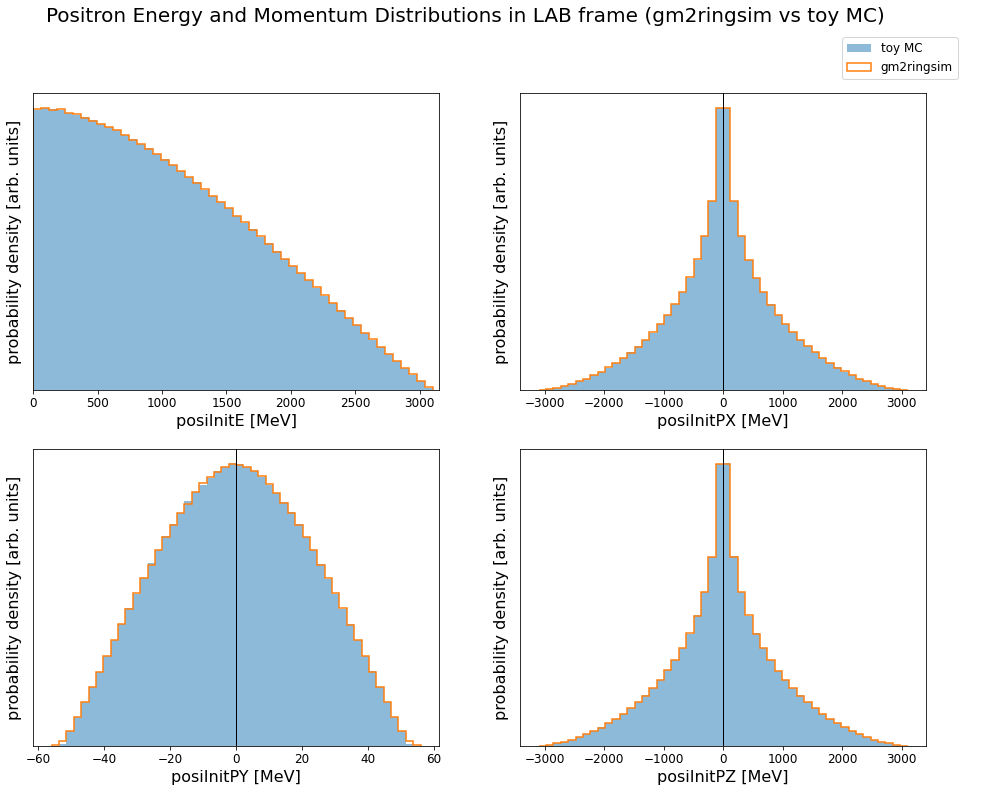

In [4]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(data_gm2ringsim['posiInitE'],range=(0,3100),density=True,bins=50,histtype='step',linewidth=1.5,label='gm2ringsim')
ax1.set_xlim([0,3150])
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_LAB[:,1],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax2.hist(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', left=False)
ax2.set_yticklabels([])

ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_LAB[:,2],range=(-56,56),bins=50,density=True,alpha=0.5)
ax3.hist(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb. units]",fontsize=16)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', left=False)
ax3.set_yticklabels([])

ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax4.hist(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb. units]",fontsize=16)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', left=False)
ax4.set_yticklabels([])


fig.legend(loc=(0.85,0.9),fontsize=12)

In [5]:
# sort out data at different cos(g2phase), for sampled data
filter1 = np.where(abs(four_momenta_LAB[:,11]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(four_momenta_LAB[:,11])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(four_momenta_LAB[:,11]+1)<=0.4 ) # ctheta= -1

four_momenta_lab_filter_1 = four_momenta_LAB[filter1]
four_momenta_lab_filter_2 = four_momenta_LAB[filter2]
four_momenta_lab_filter_3 = four_momenta_LAB[filter3]

In [6]:
# sort out data at different cos(g2phase), for gm2ringsim data
data_gm2ringsim_partial = np.zeros(shape=(2,data_gm2ringsim["posiInitE"].size))
data_gm2ringsim_partial[0] = data_gm2ringsim["posiInitE"]
data_gm2ringsim_partial[1] = data_gm2ringsim["cosg2phase"]
data_gm2ringsim_partial = data_gm2ringsim_partial.T

filter1 = np.where(abs(data_gm2ringsim_partial[:,1]-1)<=0.4 ) # ctheta= 1, theta=0
filter2 = np.where(abs(data_gm2ringsim_partial[:,1])<=0.4 )   # ctheta= 0, theta=90
filter3 = np.where(abs(data_gm2ringsim_partial[:,1]+1)<=0.4 ) # ctheta= -1, theta=180

data_gm2ringsim_partial_filter_1 = data_gm2ringsim_partial[filter1]
data_gm2ringsim_partial_filter_2 = data_gm2ringsim_partial[filter2]
data_gm2ringsim_partial_filter_3 = data_gm2ringsim_partial[filter3]

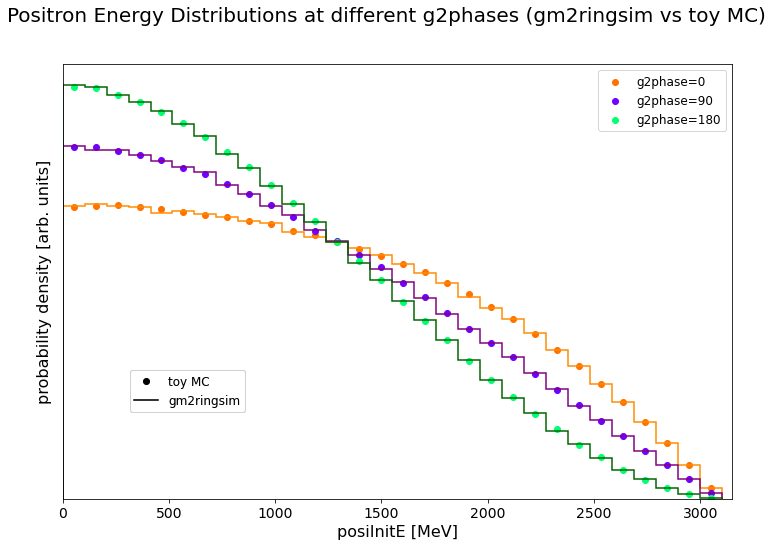

In [7]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positron Energy Distributions at different g2phases (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(data_gm2ringsim_partial_filter_1[:,0],range=(-3100,3100),bins=60,density=True,color='darkorange',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_1[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#FF7200',label='g2phase=0')

ax1.hist(data_gm2ringsim_partial_filter_2[:,0],range=(-3100,3100),bins=60,density=True,color='purple',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_2[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#7200FF',label='g2phase=90')

ax1.hist(data_gm2ringsim_partial_filter_3[:,0],range=(-3100,3100),bins=60,density=True,color='darkgreen',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_3[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#00FF72',label='g2phase=180')


ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

lgd1 = ax1.legend(fontsize=12)
ax1.add_artist(lgd1)

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [],linewidth=0, color='black', marker='o', markersize=6, label='toy MC')
line2 = mlines.Line2D([], [],linewidth=1.5, color='black', markersize=8, label='gm2ringsim')
lgd2 = ax1.legend(handles=[line1,line2],fontsize=12,loc=(0.1,0.2))
ax1.add_artist(lgd2)

# 3.3 Energy vs g2phase Distribution

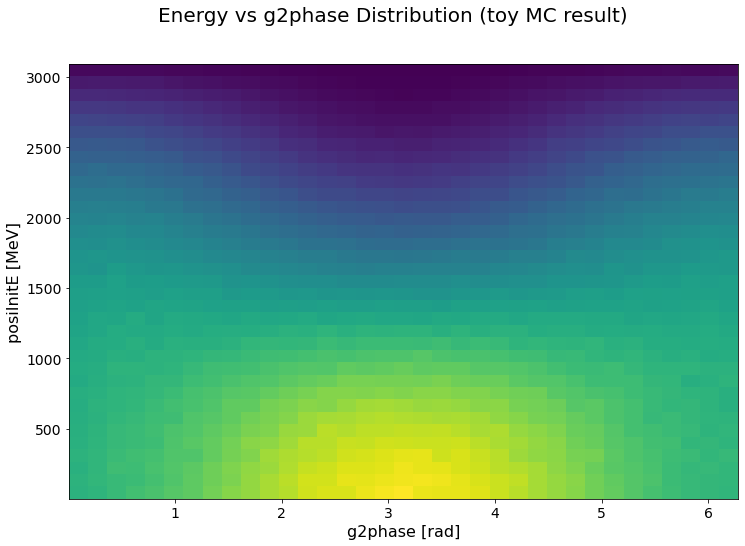

In [8]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (toy MC result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(four_momenta_LAB[:,10],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# simple BD eqn

In [ ]:
def x(t):
    x_0=0.0
    a_x=0.0
    omega_x=0.37
    phi_x=0.0
    return x_0 + a_x*np.cos(2*np.pi*omega_x*t+phi_x)
    
def y(t):
    y_0=0.0
    a_y=5.0
    omega_y=2.2
    phi_y=0.0
    return y_0 + a_y*np.cos(2*np.pi*omega_y*t+phi_y)
    
# def acceptance_x(x):
#     return 0.5 - float(x)/90

# def acceptance_y(y):
#     return 1.0 - abs(y)/45

# def n_g2(t):
#     a_g2=0.4
#     omega_a=0.23
#     phi_a=0.0
#     return 1 + a_g2*np.cos(2*np.pi*omega_a*t+phi_a)

In [ ]:
n_point = 10000
x_beam_pts = np.ndarray(n_point)
y_beam_pts = np.ndarray(n_point)
time_pts = np.ndarray(n_point)

for i in range(n_point):
    time_pts[i]=i/100 ## set time to 0.1 us or 100 ns
    x_beam_pts[i]=x(time_pts[i])
    y_beam_pts[i]=y(time_pts[i])

In [3]:
import sys, os, shutil
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt


sys.path.insert(1,'../02_positron_sampling')
# from PositronDecay import GenerateMichelKinematics, GeneratePositron_MRF, Calculate_Phase, GeneratePositron_LAB
# from Constants import EMMU, EMASS, pi, twopi, fine_structure_const

import PositronDecay

In [9]:
x = PositronDecay.GenerateMichelKinematics
x()

(0.48089016149068176, 0.6954168203214759)

In [43]:
np.random.seed(2022)
print(np.random.random())

0.009358613807764704
